In [82]:
%load_ext autoreload
%autoreload 2
import warnings
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import matplotlib.pyplot as plt
import numpy as np

# Get model Configs
from omegaconf import OmegaConf, DictConfig

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import pickle as pkl

# Load the model, data pipeline and metrics
from jOpMRI.models.joint_model import AcqRecModel
from jOpMRI.data.tfrecords.vcc import read_data
from jOpMRI.data.utils import shuffle_batch_prefetch
from jOpMRI.utils.debug_imports import show_trajectories
from jOpMRI.utils.evaluate import box_ssim, box_psnr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load 2D MRI data
X, y_true = np.load('AXT1.npy')

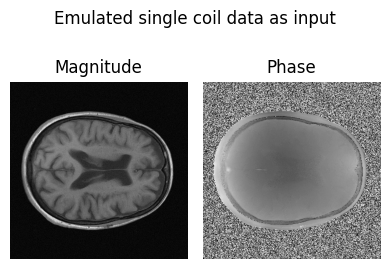

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(4, 3))
axs[0].imshow(np.abs(X), cmap='gray')
axs[0].set_title('Magnitude')
axs[1].imshow(np.angle(X), cmap='gray')
axs[1].set_title('Phase')
for i in [0, 1]:
    axs[i].axis('off')
fig.suptitle('Emulated single coil data as input')
plt.tight_layout()

In [75]:
model_cfg = OmegaConf.load('./model_params.yaml')
jOpModel = AcqRecModel(
        trajectory_kwargs=model_cfg['trajectory'],
        acq_kwargs=model_cfg['acquisition'],
        recon_kwargs=model_cfg['reconstruction'],
        opt_kwargs=model_cfg['train']['optimizer'],
        nufft_implementation='tfkbnufft',
        batch_size=1,
        cfg=model_cfg,
)
y = jOpModel(X[None, None, :]) # Add dummy dimensions for channels and batch

/volatile/Chaithya/Environments/jopmri/lib/python3.8/site-packages/tfkbnufft/kbnufft.py:47: UserWarning: The gradient w.r.t trajectory is Experimental and WIP. Please use with caution
  warnings.warn('The gradient w.r.t trajectory is Experimental and WIP. '


Optimizing for Ns : 513


In [93]:
model = 'SPARKLING'
jOpModel.continue_load_weights(model + '.h5', load_opt=False)
y = jOpModel(X[None, None, ...])[0][0].numpy()

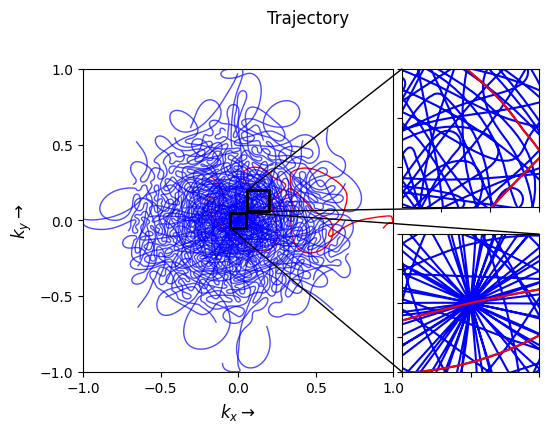

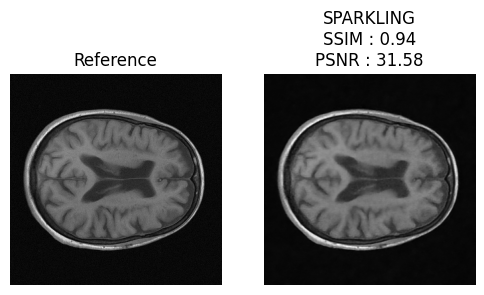

In [100]:
fig = plt.figure(figsize=(6, 6))
show_trajectories(fig, jOpModel.trainable_variables[0].numpy())
fig.suptitle('Trajectory')
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
for i, I in enumerate([y_true, y]):
    ax[i].imshow(np.abs(I), cmap='gray')
    ax[i].axis('off')
    if i == 1:
        ax[i].set_title(
            model + 
            '\nSSIM : ' + str(np.around(box_ssim(y, y_true), 2)) + 
            '\nPSNR : ' + str(np.around(box_psnr(y, y_true), 2))
            )
    else:
        ax[i].set_title('Reference')

In [101]:
model = 'PROJeCTOR'
jOpModel.continue_load_weights(model + '.h5', load_opt=False)
y = jOpModel(X[None, None, ...])[0][0].numpy()

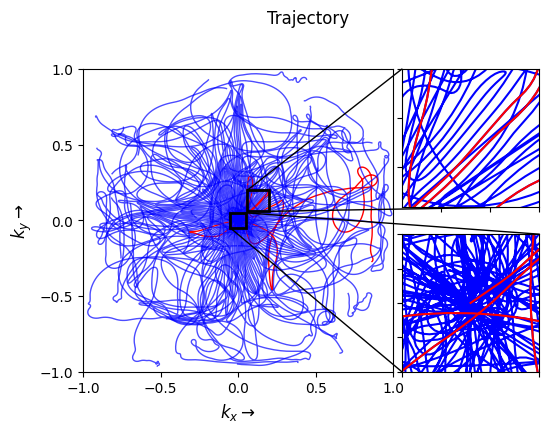

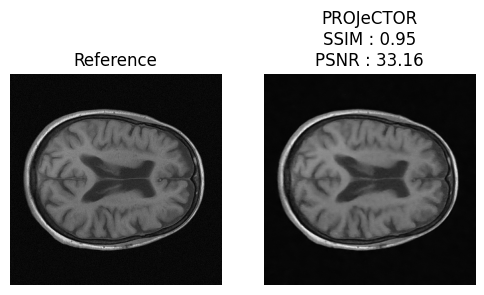

In [102]:
fig = plt.figure(figsize=(6, 6))
show_trajectories(fig, jOpModel.trainable_variables[0].numpy())
fig.suptitle('Trajectory')
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
for i, I in enumerate([y_true, y]):
    ax[i].imshow(np.abs(I), cmap='gray')
    ax[i].axis('off')
    if i == 1:
        ax[i].set_title(
            model + 
            '\nSSIM : ' + str(np.around(box_ssim(y, y_true), 2)) + 
            '\nPSNR : ' + str(np.around(box_psnr(y, y_true), 2))
            )
    else:
        ax[i].set_title('Reference')